<a href="https://colab.research.google.com/github/Fanusaez/7506R-2C2022-GRUPO13/blob/sabado-1-10-2022/7506R_TP1_GRUPO13_ENTREGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Practico 1 : Propiedades en Venta
## Grupo 13
### Integrantes:
- Ivan Manuel Pensado
- Axel Tomas Higa
- Edgardo Francisco Saez 
- Lautaro Barrionuevo
- Nicolás Carreño

# Importe de librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


import scipy.stats as st

from sklearn.neighbors import LocalOutlierFactor

import matplotlib.pyplot as plt


# Lectura de archivo

In [2]:
ds_propiedades = pd.read_csv('properati_argentina_2021.csv')

In [3]:
ds_propiedades.head()

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
0,XZq2dFGxBiboHY3Bo/tqlw==,2021-09-09,2022-01-27,2021-09-09,-38.957632,-68.105443,Neuquén,NaN,NaN,NaN,NaN,Venta,Casa,6.0,NaN,NaN,206.0,NaN,NaN,Casa - Capital
1,8afoK+yMH/rnnlYiktwgNA==,2021-09-09,2021-10-23,2021-09-09,-34.888878,-56.092368,Montevideo,NaN,NaN,NaN,NaN,Venta,Casa,4.0,3.0,193.0,193.0,390000.0,USD,Casa - Malvín
2,iVaG5rBB47dd1Ya4BMXREA==,2021-09-09,2022-03-09,2021-09-09,-32.488717,-58.257499,Entre Ríos,NaN,NaN,NaN,NaN,Venta,Casa,NaN,NaN,110.0,45.0,47000.0,USD,Casa - Uruguay
3,QE1QVMWKAHWkd0qT0FtPWA==,2021-09-09,2022-01-27,2021-09-09,-34.900165,-54.808453,Maldonado,NaN,NaN,NaN,NaN,Venta,Casa,NaN,3.0,NaN,180.0,400000.0,USD,Casa - El Chorro
4,tJ5lSk7IysG/71OGhacNZA==,2021-09-09,2022-01-27,2021-09-09,-38.954528,-68.041862,Neuquén,NaN,NaN,NaN,NaN,Venta,PH,3.0,2.0,NaN,98.0,102000.0,USD,PH - Villa Farrell


# Análisis Exploratorio y Preprocesamiento de Dato

***Filtrado inicial***

Se deben filtrar únicamente los anuncios de propiedades de tipo vivienda ( Casa, PH y Departamento ) ubicados en Capital Federal cuyo tipo de operación sea venta y su precio se encuentre en dólares (USD).

In [4]:
ds_prop_filtrado = ds_propiedades[ds_propiedades.place_l2.str.contains('Capital Federal', case=False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_type.str.fullmatch('Departamento|Casa|ph', case = False, na = False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.operation.str.contains('venta', case=False, na =  False)]
ds_prop_filtrado = ds_prop_filtrado[ds_prop_filtrado.property_currency.str.contains('USD', case=False, na =  False)]  #Preguntar si el na va en true

***Exploración inicial***

Tipo de variable

In [5]:
ds_prop_filtrado.dtypes

id                           object
start_date                   object
end_date                     object
created_on                   object
latitud                     float64
longitud                    float64
place_l2                     object
place_l3                     object
place_l4                     object
place_l5                     object
place_l6                    float64
operation                    object
property_type                object
property_rooms              float64
property_bedrooms           float64
property_surface_total      float64
property_surface_covered    float64
property_price              float64
property_currency            object
property_title               object
dtype: object

Variables Cuantitativas

In [6]:
cuantitativos = ["latitud", "longitud", "property_rooms", "property_bedrooms","property_surface_total", "property_surface_covered", "property_price"]
ds_cuantitativo = ds_prop_filtrado.loc[:,cuantitativos]
ds_resumen_cuantitativo = pd.DataFrame()
ds_resumen_cuantitativo["media"] = ds_cuantitativo.mean()
ds_resumen_cuantitativo["mediana"] = ds_cuantitativo.median()
ds_resumen_cuantitativo["q1"] = ds_cuantitativo.quantile([.25]).iloc[0]
ds_resumen_cuantitativo["q3"] = ds_cuantitativo.quantile([.75]).iloc[0]
ds_resumen_cuantitativo["moda"] = ds_cuantitativo.mode().iloc[0]
ds_resumen_cuantitativo

,media,mediana,q1,q3,moda
latitud,-34.591481,-34.59579,-34.615975,-34.577413,-34.541250
longitud,-58.449795,-58.43900,-58.466522,-58.408862,-58.472966
property_rooms,2.822799,3.00000,2.000000,4.000000,3.000000
property_bedrooms,2.014629,2.00000,1.000000,3.000000,1.000000
property_surface_total,109.092970,65.00000,45.000000,105.000000,50.000000
property_surface_covered,87.931932,58.00000,40.000000,88.000000,40.000000
property_price,226238.207185,143900.00000,95000.000000,237000.000000,110000.000000


Variables Cualitativas

In [7]:
cualitativos = ["place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_cualitativo = ds_prop_filtrado.loc[:,cualitativos]

* Mostrar cantidad de valores posibles

In [8]:
ds_cualitativo.nunique()

place_l2                 1
place_l3                57
operation                1
property_type            3
property_currency        1
property_title       55704
dtype: int64

* Mostrar frecuencias
    * Obviamos las opciones de un solo tipo porque la frecuencia es de 100%

In [9]:
ds_cualitativo.place_l3.value_counts(normalize=True)* 100

Palermo                 15.248529
Belgrano                 9.482906
Caballito                7.639185
Recoleta                 6.694944
Villa Urquiza            4.980177
Almagro                  4.349263
Nuñez                    3.779095
Villa Crespo             3.398627
Flores                   3.314434
Barrio Norte             3.170560
Balvanera                2.720820
Colegiales               2.079248
Villa Devoto             2.047276
Villa del Parque         1.949228
Saavedra                 1.949228
Puerto Madero            1.591142
San Telmo                1.470714
San Cristobal            1.385455
San Nicolás              1.380126
Retiro                   1.332168
Barracas                 1.327905
Boedo                    1.318314
Floresta                 1.273553
Monserrat                1.188294
Parque Chacabuco         1.143533
Villa Pueyrredón         1.077458
Coghlan                  1.048683
Villa Luro               0.774789
Mataderos                0.766263
Chacarita     

In [10]:
ds_cualitativo.property_type.value_counts(normalize=True)* 100

Departamento    85.761122
PH               9.831404
Casa             4.407474
Name: property_type, dtype: float64

In [11]:
ds_cualitativo.property_title.value_counts(normalize=True)* 100

Departamento - Palermo                                                                                  1.557576
Departamento - Recoleta                                                                                 1.404789
Departamento - Belgrano                                                                                 1.180914
Departamento - Caballito                                                                                0.993114
Departamento - Almagro                                                                                  0.706639
                                                                                                          ...   
Gran 3 ambientes en pleno Villa del Parque                                                              0.001061
Venta PH 3 Amb Con Patio Flores                                                                         0.001061
Venta, PH, 3 Ambientes, PB, Quincho, Parrilla, Terraza, Paternal                                

* Determinar variables irrelevantes en el análisis

Debido a que las caracteristicas cualitativas "place_l2", "operation", "Property_currency" solo poseen un valor posible, es irrelevante para el analisis de datos. Tambien la caracteristica de "Property_title" al ser una descripcion del vendedor no aporta mucha informacion analitica. Por ultimo, los datos que no aportan al analisis, son las fechas, de las columnas "Start_date", "End_date" y "Created_on" debido a que no se especifica que significa dichas fechas. 

In [12]:
columnas_a_eliminar = ["id","place_l5","place_l6"] # variables irrelevantes, podrian ser: property_title place_l5	place_l6 y (start_date created_on) son lo mismo
ds_filtado_copia = ds_prop_filtrado.copy()
ds_filtado_copia.drop(columns = columnas_a_eliminar, inplace = True)

* Realizar un análisis gráfico de las distribuciones de las variables

In [13]:

#sns.pairplot(ds_filtado_copia)

###Correlaciones existentes entre las variables




*   Analizar las correlaciones existentes entre las variables.



In [14]:
ds_prop_filtrado.corr()

,latitud,longitud,place_l6,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.239235,NaN,0.005521,0.003162,0.025348,0.002352,0.016635
longitud,-0.239235,1.000000,NaN,-0.008324,-0.008556,-0.015056,-0.001155,0.023314
place_l6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
property_rooms,0.005521,-0.008324,NaN,1.000000,0.871940,0.067211,0.076097,0.488934
property_bedrooms,0.003162,-0.008556,NaN,0.871940,1.000000,0.067702,0.075075,0.425386
property_surface_total,0.025348,-0.015056,NaN,0.067211,0.067702,1.000000,0.604311,0.085235
property_surface_covered,0.002352,-0.001155,NaN,0.076097,0.075075,0.604311,1.000000,0.056238
property_price,0.016635,0.023314,NaN,0.488934,0.425386,0.085235,0.056238,1.000000


Precio promedio de propiedad por Barrio

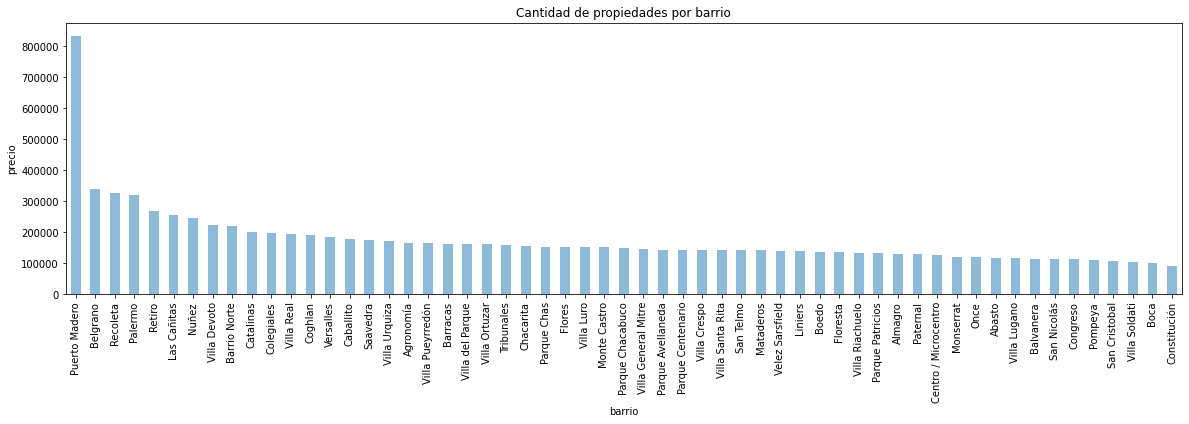

In [15]:
ds_precio_prom = ds_prop_filtrado.groupby(["place_l3"])["property_price"].mean().sort_values(ascending=False)
grf_ds=ds_precio_prom.plot.bar(alpha=0.5 , title="Cantidad de propiedades por barrio" , xlabel="barrio" , ylabel="precio", figsize=(20,5))

# Datos faltantes

Realizar análisis de datos faltantes a nivel de columna. Graficar para cada variable
el porcentaje de datos faltantes con respecto al total del dataset

In [16]:
filas_totales=ds_prop_filtrado.shape[0]
print(ds_prop_filtrado.isna().sum()/filas_totales*100)

id                            0.000000
start_date                    0.000000
end_date                      0.000000
created_on                    0.000000
latitud                       3.957602
longitud                      3.957602
place_l2                      0.000000
place_l3                      0.442445
place_l4                     96.134707
place_l5                    100.000000
place_l6                    100.000000
operation                     0.000000
property_type                 0.000000
property_rooms                1.107704
property_bedrooms            11.657418
property_surface_total        5.139577
property_surface_covered      3.558658
property_price                0.000000
property_currency             0.000000
property_title                0.000000
dtype: float64


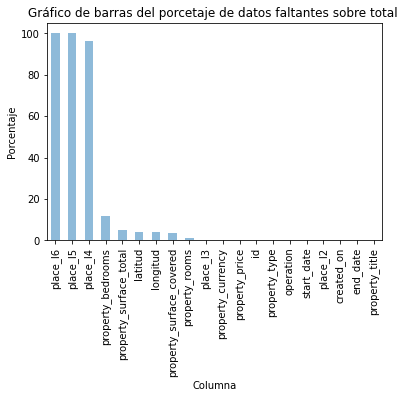

In [17]:
ds_porcentaje = ds_prop_filtrado.isna().sum()/filas_totales*100
ds_porcentaje = ds_porcentaje.sort_values(ascending=False)
grf_ds = ds_porcentaje.plot.bar(alpha=0.5 , title="Gráfico de barras del porcetaje de datos faltantes sobre total " , xlabel="Columna" , ylabel="Porcentaje")

Nos fijamos si hay algun valor sospechoso que sea negativo

In [18]:
columnas_con_numeros = ['property_price', 'property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']
(ds_prop_filtrado[columnas_con_numeros] <= 0).any().to_frame('Menor que 0 ?')

,Menor que 0 ?
property_price,False
property_surface_total,False
property_surface_covered,False
property_rooms,False
property_bedrooms,True


Property_bedrooms tiene numero negativo, asi que veo cuantos hay

In [19]:
ds_prop_filtrado[ds_prop_filtrado['property_bedrooms'] < 1]

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
406880,3WI+zCCMeb9TR5kOBm7rhg==,2021-01-07,2021-03-18,2021-01-07,-34.577595,-58.495185,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,-1.0,61.0,43.0,125000.0,USD,Jardines de Roosevelt - Hermoso 3 ambientes co...


Solo hay uno asi que se lo coloca en nan porque no condiciona el analisis pero si el dato es incorrecto

In [20]:
ds_prop_filtrado.loc[ds_prop_filtrado['property_bedrooms'] < 1,'property_bedrooms'] = np.nan
ds_prop_filtrado[ds_prop_filtrado['id'] == '3WI+zCCMeb9TR5kOBm7rhg==']

,id,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,place_l4,place_l5,place_l6,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
406880,3WI+zCCMeb9TR5kOBm7rhg==,2021-01-07,2021-03-18,2021-01-07,-34.577595,-58.495185,Capital Federal,Villa Urquiza,NaN,NaN,NaN,Venta,Departamento,2.0,NaN,61.0,43.0,125000.0,USD,Jardines de Roosevelt - Hermoso 3 ambientes co...


Tomando en cuenta estos resultados, decidimos eliminar las columnas l4 , l5 y l6 debido a que el porcentaje de datos faltantes es total o casi total. En el caso de l5 y l6 son de 100 por ciento por lo cual no se podria completar y en el caso de l4 son las subdivisiones barriales de los cuales muchos no poseen.

In [21]:
columnas_a_eliminar = ["place_l4","place_l5","place_l6","id"]
ds_prop_filtrado.drop(columns = columnas_a_eliminar, inplace = True)

Realizar un análisis de datos faltantes a nivel de fila. Calcular el porcentaje de
datos faltantes de cada registro. Realizar un gráfico que permita conocer la
proporción de faltantes por fila en el dataset.

In [22]:
filas_cantidad_nan = pd.DataFrame(ds_prop_filtrado).isna().sum(axis=1).to_frame("cantidad")
cantidad = len(filas_cantidad_nan[filas_cantidad_nan["cantidad"] > 0])
print(f"Hay {cantidad} lineas que poseen uno o mas valores faltantes")

Hay 21387 lineas que poseen uno o mas valores faltantes


Verificamos que no haya duplicados y las eliminamos

In [23]:
print(ds_prop_filtrado[ds_prop_filtrado.duplicated(keep=False)])
ds_prop_filtrado = ds_prop_filtrado.drop_duplicates()

        start_date    end_date  created_on    latitud   longitud  \
1093    2021-09-09  2022-01-27  2021-09-09 -34.604660 -58.395385   
1094    2021-09-09  2022-01-27  2021-09-09 -34.604660 -58.395385   
1095    2021-09-09  2022-01-27  2021-09-09 -34.604660 -58.395385   
1096    2021-09-09  2022-01-27  2021-09-09 -34.604660 -58.395385   
1239    2021-09-09  2022-02-09  2021-09-09 -34.580818 -58.491051   
...            ...         ...         ...        ...        ...   
459606  2021-01-05  2021-01-10  2021-01-05 -34.555751 -58.463942   
459953  2021-01-05  2021-03-06  2021-01-05 -34.605691 -58.443852   
459959  2021-01-05  2021-03-06  2021-01-05 -34.605691 -58.443852   
459961  2021-01-05  2021-04-08  2021-01-05 -34.599486 -58.432429   
459962  2021-01-05  2021-04-08  2021-01-05 -34.599486 -58.432429   

               place_l2       place_l3 operation property_type  \
1093    Capital Federal   Barrio Norte     Venta  Departamento   
1094    Capital Federal   Barrio Norte     Venta  D

*Determinar, de ser posible, estrategias para reparar los valores faltantes.*

Primero procedemos imputando los cualitativos, que en este caso solo es el place_l3.
Utilizando un archivo csv proporcionado por el gobierno de la Ciudad Autonoma de Buenos Aires, el cual nos proporcionorá el nombre de la localidad usando latitud y longitud, mediante la utilizacion de Polygon.
https://data.buenosaires.gob.ar/dataset/barrios

In [24]:
ds_barrios = pd.read_csv('barrios.csv', header=0,sep=';')

from shapely.geometry import MultiPolygon, Polygon, Point
from shapely import wkt
ds_barrios.WKT = ds_barrios.WKT

for index, registro_prop in ds_prop_filtrado.iterrows():
    if  type(registro_prop["place_l3"]) is str:
        continue
    for index_, registro_barrio in ds_barrios.iterrows():
        if wkt.loads(registro_barrio.WKT).covers(Point(registro_prop.longitud,registro_prop.latitud)):
            barrio_aux = registro_barrio['BARRIO']
            ds_prop_filtrado.loc[index, 'place_l3'] = barrio_aux

Me fijo si quedo algun place_l3 incompleto.

In [25]:
ds_prop_filtrado[ds_prop_filtrado["place_l3"].isna()]

,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
25,2021-09-09,2021-09-26,2021-09-09,NaN,NaN,Capital Federal,NaN,Venta,Casa,4.0,3.0,171.0,133.0,210000.0,USD,VENTA CASA LLAVE EN MANO - COSTA ESMERALDA
3088,2021-02-20,2022-02-09,2021-02-20,-31.6789,-63.87964,Capital Federal,NaN,Venta,Casa,5.0,4.0,220.0,220.0,230000.0,USD,VENTA HERMOSA CASA 5 AMB. C/PILETA - BOCA RATÓN
3099,2021-02-20,2021-03-01,2021-02-20,NaN,NaN,Capital Federal,NaN,Venta,Casa,3.0,2.0,69.0,53.0,54600.0,USD,Venta Duplex 3 amb. Complejo Quimaral I - San ...
5942,2021-10-29,2022-01-08,2021-10-29,NaN,NaN,Capital Federal,NaN,Venta,Departamento,3.0,2.0,87.0,87.0,117000.0,USD,impecable 3 Ambientes de 88 m2!!!! con 2 baños...
6699,2021-02-09,2021-06-05,2021-02-09,NaN,NaN,Capital Federal,NaN,Venta,Casa,NaN,3.0,NaN,390.0,795000.0,USD,Magnífica casa a la venta de 7 ambientes en Ab...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
458690,2021-01-05,2021-03-01,2021-01-05,NaN,NaN,Capital Federal,NaN,Venta,Casa,NaN,2.0,NaN,80.0,120000.0,USD,Casa a reciclar 3 Amb. en San Martin
458696,2021-01-05,2021-03-01,2021-01-05,NaN,NaN,Capital Federal,NaN,Venta,Casa,NaN,2.0,60.0,60.0,75000.0,USD,CASA 3 AMBIENTES CON TERRAZA
459187,2021-01-05,2021-03-01,2021-01-05,NaN,NaN,Capital Federal,NaN,Venta,Departamento,2.0,1.0,41.0,41.0,75000.0,USD,San Martín. Centro depto 2 amb a estrenar.
459195,2021-01-05,2021-03-01,2021-01-05,NaN,NaN,Capital Federal,NaN,Venta,Departamento,2.0,1.0,44.0,44.0,128000.0,USD,San Martin Ctro. s/ San Lorenzo Impecable Dpto...


Eliminamos aquellas que no tengan place_l3 porque no se pueden completar por el barrio o tienen mal el dato ej dato con latitud -31.678 y longitud -63.87964 pertenece a Cordoba pero place_l2 es Capital federal por lo que puede ser que el dato este subido erroneamente y tambien eliminamos los registus sin latidu ni longitu porque no es posible saber su dato exacto y puede ser un regiistro mal cargado. Y vemos cuantos datos faltantes quedan.

In [26]:
ds_prop_filtrado = ds_prop_filtrado[~ds_prop_filtrado["place_l3"].isna() & ~ds_prop_filtrado["latitud"].isna() & ~ds_prop_filtrado["longitud"].isna()]
filas_totales=ds_prop_filtrado.shape[0]
print(ds_prop_filtrado.isna().sum()/filas_totales*100)

start_date                   0.000000
end_date                     0.000000
created_on                   0.000000
latitud                      0.000000
longitud                     0.000000
place_l2                     0.000000
place_l3                     0.000000
operation                    0.000000
property_type                0.000000
property_rooms               0.959856
property_bedrooms           11.517156
property_surface_total       5.031397
property_surface_covered     3.544517
property_price               0.000000
property_currency            0.000000
property_title               0.000000
dtype: float64


Luego imputaremos los datos cuantitativos faltantes utilizando el metodo MICE.

In [27]:
copia_pre_imputacion= ds_prop_filtrado.copy()
mice = ds_prop_filtrado.copy()
#mice= mice[~mice["latitud"].isna() & ~mice["place_l3"].isna()]
columnas=['property_surface_total','property_surface_covered','property_rooms','property_bedrooms'] #,'property_surface_covered','property_bathrooms','property_rooms','property_price'
df_eliminar_nans_op3=ds_prop_filtrado[columnas].copy()

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=20, verbose=0, random_state=0,imputation_order='roman',initial_strategy = "mean", min_value=0) #imputation_order='roman'
df_eliminar_nans_op3_completo=imp.fit_transform(df_eliminar_nans_op3)
mice['property_surface_total']= df_eliminar_nans_op3_completo[:,0]
mice['property_surface_covered']=df_eliminar_nans_op3_completo[:, 1]
mice['property_rooms']= df_eliminar_nans_op3_completo[:, 2]
#mice['property_price']= df_eliminar_nans_op3_completo[:, 3]
mice['property_bedrooms'] = df_eliminar_nans_op3_completo[:,3]
#mice['latitud'] = df_eliminar_nans_op3_completo[:,5]
#mice['longitud'] = df_eliminar_nans_op3_completo[:,6]
#mice['latitud'].drop()
#mice['longitud'].drop()
mice=mice.round(decimals = 4)


In [28]:
filas_totales=mice.shape[0]
print(mice.isna().sum()/filas_totales*100)

start_date                  0.0
end_date                    0.0
created_on                  0.0
latitud                     0.0
longitud                    0.0
place_l2                    0.0
place_l3                    0.0
operation                   0.0
property_type               0.0
property_rooms              0.0
property_bedrooms           0.0
property_surface_total      0.0
property_surface_covered    0.0
property_price              0.0
property_currency           0.0
property_title              0.0
dtype: float64


Chequeamos que la imputacion no haya creado datos erroneos negativos

In [29]:
columnas_con_numeros = ['property_price', 'property_surface_total', 'property_surface_covered', 'property_rooms', 'property_bedrooms']
(mice[columnas_con_numeros] < 0).any().to_frame('Menor que 0 ?')

,Menor que 0 ?
property_price,False
property_surface_total,False
property_surface_covered,False
property_rooms,False
property_bedrooms,False


In [30]:
mice[mice['property_surface_covered']==0]

,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
2773,2021-12-17,2022-01-27,2021-12-17,-34.5924,-58.3963,Capital Federal,Barrio Norte,Venta,Departamento,1.0,0.5221,20.0,0.0,47000.0,USD,Departamento - Barrio Norte
10828,2021-01-13,2021-09-14,2021-01-13,-34.6019,-58.4113,Capital Federal,Abasto,Venta,Departamento,1.0,1.0000,18.0,0.0,38000.0,USD,Departamento - Abasto
60741,2021-07-18,2021-08-02,2021-07-18,-34.6028,-58.3972,Capital Federal,Balvanera,Venta,Departamento,1.0,0.5221,18.0,0.0,45000.0,USD,Departamento - Balvanera
95129,2021-09-24,2021-12-10,2021-09-24,-34.6036,-58.3768,Capital Federal,San Nicolás,Venta,Departamento,1.0,0.5221,20.0,0.0,39000.0,USD,Departamento 1 AMB. OFICINA O VIVIENDA - Cent...
106084,2021-03-11,2021-06-05,2021-03-11,-34.6178,-58.3794,Capital Federal,San Telmo,Venta,Departamento,1.0,0.5221,20.0,0.0,50000.0,USD,Departamento - San Telmo
137881,2021-01-22,2021-06-05,2021-01-22,-34.6036,-58.3768,Capital Federal,San Nicolás,Venta,Departamento,1.0,0.5221,20.0,0.0,42000.0,USD,Departamento 1 AMB. OFICINA O VIVIENDA - Cent...
139662,2021-07-15,2021-08-24,2021-07-15,-34.5925,-58.3953,Capital Federal,Barrio Norte,Venta,Departamento,1.0,0.5221,20.0,0.0,59000.0,USD,Departamento - Barrio Norte
153464,2021-12-09,2021-12-15,2021-12-09,-34.6036,-58.3768,Capital Federal,San Nicolás,Venta,Departamento,1.0,0.5221,20.0,0.0,39000.0,USD,Departamento 1 AMB. con baño y cocina kitchen...
306760,2021-03-04,2021-06-05,2021-03-04,-34.6008,-58.3899,Capital Federal,San Nicolás,Venta,Departamento,1.0,0.5221,20.0,0.0,53000.0,USD,Departamento - San Nicolas
328146,2021-12-14,2022-01-19,2021-12-14,-34.6036,-58.3768,Capital Federal,San Nicolás,Venta,Departamento,1.0,0.5221,20.0,0.0,35800.0,USD,Departamento 1 AMB. con baño y cocina kitchen...


En caso de realizar imputaciones comparar las distribuciones de cada atributo
reparado con la distribución anterior a la imputación de los datos faltantes.

***Comparamos property price sin y con imputacion***

<AxesSubplot:ylabel='property_price'>

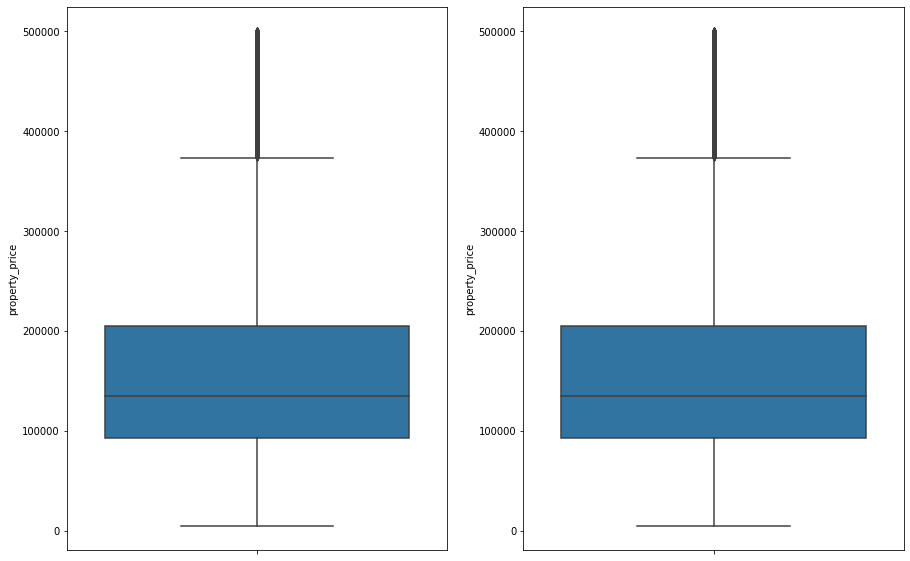

In [31]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_price", data=copia_pre_imputacion[copia_pre_imputacion["property_price"]<500000], ax=axes[0])
sns.boxplot(y="property_price", data=mice[mice["property_price"]<500000], ax=axes[1])

***Comparamos property bedrooms***

<AxesSubplot:>

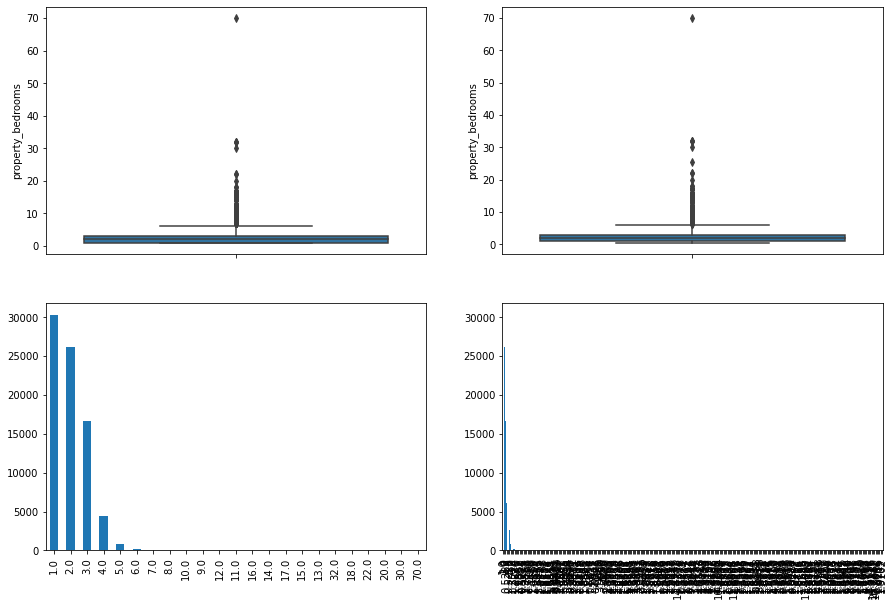

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_size_inches(15,10)
sns.boxplot(y="property_bedrooms", data=copia_pre_imputacion, ax=axes[0,0])
sns.boxplot(y="property_bedrooms", data=mice, ax=axes[0,1])
copia_pre_imputacion["property_bedrooms"].value_counts().plot.bar(ax=axes[1,0])
mice["property_bedrooms"].value_counts().plot.bar(ax=axes[1,1])

El grafico nos muestra que la mayoria de los valores faltantes se complentan co una sola habitacion

In [33]:
mice[mice.duplicated(keep=False)]

,start_date,end_date,created_on,latitud,longitud,place_l2,place_l3,operation,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_currency,property_title
89489,2021-05-14,2021-06-05,2021-05-14,-34.5969,-58.3838,Capital Federal,Recoleta,Venta,Departamento,10.0000,6.0000,388.0,311.0,650000.0,USD,Excelente departamento Francés frente a Plaza ...
89491,2021-05-14,2021-06-05,2021-05-14,-34.5969,-58.3838,Capital Federal,Recoleta,Venta,Departamento,10.0000,6.0000,388.0,311.0,650000.0,USD,Excelente departamento Francés frente a Plaza ...
203772,2021-05-10,2021-06-05,2021-05-10,-34.5775,-58.4391,Capital Federal,Palermo,Venta,Departamento,1.0000,0.5223,40.0,40.0,180000.0,USD,Departamento - Palermo
203806,2021-05-10,2021-06-05,2021-05-10,-34.5775,-58.4391,Capital Federal,Palermo,Venta,Departamento,1.0000,0.5223,40.0,40.0,180000.0,USD,Departamento - Palermo
268256,2021-07-09,9999-12-31,2021-07-09,-34.5793,-58.4544,Capital Federal,Colegiales,Venta,Departamento,2.0000,1.0000,51.0,51.0,132600.0,USD,Departamento - Colegiales
268261,2021-07-09,9999-12-31,2021-07-09,-34.5793,-58.4544,Capital Federal,Colegiales,Venta,Departamento,2.0000,1.0000,51.0,51.0,132600.0,USD,Departamento - Colegiales
336381,2021-07-21,2022-07-07,2021-07-21,-34.5792,-58.4544,Capital Federal,Colegiales,Venta,Departamento,1.8769,1.0000,27.0,27.0,63000.0,USD,Departamento - Colegiales
336384,2021-07-21,2022-07-07,2021-07-21,-34.5792,-58.4544,Capital Federal,Colegiales,Venta,Departamento,1.8769,1.0000,27.0,27.0,63000.0,USD,Departamento - Colegiales
422039,2021-07-07,2021-08-01,2021-07-07,-34.6155,-58.4244,Capital Federal,Almagro,Venta,Departamento,1.0000,0.5222,36.0,33.0,76000.0,USD,Departamento a estrenar - Almagro - Monoambiente
422043,2021-07-07,2021-08-01,2021-07-07,-34.6155,-58.4244,Capital Federal,Almagro,Venta,Departamento,1.0000,0.5222,36.0,33.0,76000.0,USD,Departamento a estrenar - Almagro - Monoambiente


# Analizar la existencia de valores atípicos


### Detectar valores atípicos en los datos en forma univariada

In [35]:
ds_atipicos = mice.copy()
ds_atipicos_copia = mice.copy()
columnas_a_eliminar = ["start_date", "end_date", "created_on", "latitud", "longitud", "place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title"]
ds_atipicos.drop(columns = columnas_a_eliminar, inplace=True)

property_rooms

In [36]:
#z-score Rooms con librería stats
ds_atipicos['z_rooms']=st.zscore(ds_atipicos.property_rooms) #Agregamos columna con valores de z-score

#z-score modificado Rooms con librería stats
mediana_rooms = np.median(ds_atipicos.property_rooms)
MAD=np.median(np.absolute(ds_atipicos.property_rooms - mediana_rooms)) #Mediana de los desvios absolutos
ds_atipicos['zm_rooms']=(ds_atipicos.property_rooms - mediana_rooms)*0.6745/MAD

Una vez realizado el calculo vemos aquellas muestras que no respetan la "regla de oro"

In [37]:
ds_atipicos[ds_atipicos['z_rooms'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms
58,10.0,10.0,394.0,244.0,500000.0,5.023524,4.7215
834,9.0,4.0,390.0,340.0,1200000.0,4.322762,4.0470
1040,8.0,6.0,201.0,201.0,345000.0,3.622001,3.3725
1108,8.0,6.0,201.0,201.0,345000.0,3.622001,3.3725
1349,8.0,6.0,201.0,201.0,345000.0,3.622001,3.3725
...,...,...,...,...,...,...,...
459306,8.0,4.0,225.0,225.0,740000.0,3.622001,3.3725
459724,8.0,3.0,285.0,272.0,1250000.0,3.622001,3.3725
459755,8.0,5.0,431.0,415.0,2800000.0,3.622001,3.3725
459764,8.0,4.0,383.0,383.0,1700000.0,3.622001,3.3725


In [38]:
ds_atipicos[ds_atipicos['z_rooms'] < -3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms


<AxesSubplot:ylabel='property_rooms'>

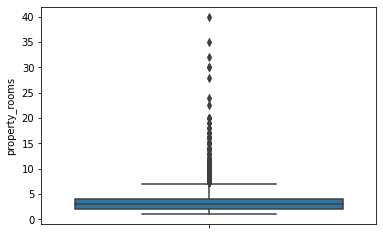

In [39]:
sns.boxplot(y=ds_atipicos.property_rooms)

property_bedrooms

In [40]:
#z-score
ds_atipicos['z_bedrooms']=st.zscore(ds_atipicos.property_bedrooms)

#z-score modificado
mediana_bedrooms = np.median(ds_atipicos.property_bedrooms)
MAD=np.median(np.absolute(ds_atipicos.property_bedrooms - mediana_bedrooms)) #Mediana de los desvios absolutos
ds_atipicos['zm_bedrooms']=(ds_atipicos.property_bedrooms - mediana_bedrooms)*0.6745/MAD

In [41]:
ds_atipicos[ds_atipicos['z_bedrooms'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms
58,10.0,10.0,394.0,244.0,500000.0,5.023524,4.7215,7.014047,5.3960
1040,8.0,6.0,201.0,201.0,345000.0,3.622001,3.3725,3.566507,2.6980
1108,8.0,6.0,201.0,201.0,345000.0,3.622001,3.3725,3.566507,2.6980
1349,8.0,6.0,201.0,201.0,345000.0,3.622001,3.3725,3.566507,2.6980
1363,8.0,6.0,201.0,201.0,345000.0,3.622001,3.3725,3.566507,2.6980
...,...,...,...,...,...,...,...,...,...
457366,7.0,6.0,280.0,230.0,426000.0,2.921240,2.6980,3.566507,2.6980
457782,10.0,6.0,520.0,500.0,3300000.0,5.023524,4.7215,3.566507,2.6980
458670,5.0,6.0,125.0,100.0,265000.0,1.519717,1.3490,3.566507,2.6980
458873,12.0,12.0,820.0,820.0,550000.0,6.425046,6.0705,8.737817,6.7450


In [42]:
ds_atipicos[ds_atipicos['z_bedrooms'] < -3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms


<AxesSubplot:ylabel='property_bedrooms'>

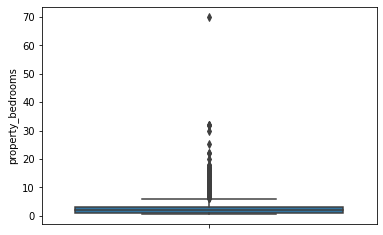

In [43]:
sns.boxplot(y=ds_atipicos.property_bedrooms)

property_surface_total

In [44]:
ds_atipicos['z_surface_total']=st.zscore(ds_atipicos.property_surface_total)
ds_atipicos[ds_atipicos['z_surface_total'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_surface_total
1140,3.8069,2.6260,10500.0000,10500.0000,9900000.0,0.683639,0.544254,0.658508,0.422237,9.135353
1932,22.4970,17.1763,186902.4938,217000.0000,250000.0,13.780937,13.150726,13.199191,10.236414,164.236828
33017,1.0000,1.0000,4428.0000,31.0000,58552.0,-1.283328,-1.349000,-0.742917,-0.674500,3.796561
34123,4.0000,3.0000,5000.0000,109.0000,418000.0,0.818956,0.674500,0.980853,0.674500,4.299491
35536,1.0000,0.5369,3660.0000,33.0000,98000.0,-1.283328,-1.349000,-1.142056,-0.986861,3.121299
72316,2.0000,1.0000,61130.0000,53030.0000,225000.0,-0.582566,-0.674500,-0.742917,-0.674500,53.651660
72521,2.0000,1.0000,33800.0000,31670.0000,66000.0,-0.582566,-0.674500,-0.742917,-0.674500,29.621822
84073,1.0000,0.6679,36000.0000,30.0000,90000.0,-1.283328,-1.349000,-1.029149,-0.898501,31.556167
94789,2.0000,1.0000,5312.0000,4809.0000,145000.0,-0.582566,-0.674500,-0.742917,-0.674500,4.573816
104177,1.0000,1.0000,3623.0000,3615.0000,110000.0,-1.283328,-1.349000,-0.742917,-0.674500,3.088767


<AxesSubplot:ylabel='property_surface_total'>

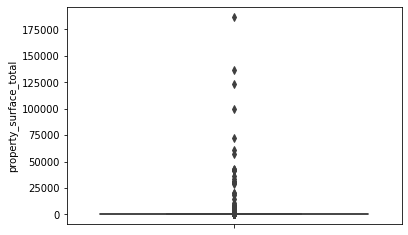

In [45]:
sns.boxplot(y=ds_atipicos.property_surface_total)

property_surface_covered

In [46]:
ds_atipicos['z_surface_covered']=st.zscore(ds_atipicos.property_surface_covered)
ds_atipicos[ds_atipicos['z_surface_covered'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_surface_total,z_surface_covered
1140,3.8069,2.6260,10500.0000,10500.0000,9900000.0,0.683639,0.544254,0.658508,0.422237,9.135353,10.409469
1932,22.4970,17.1763,186902.4938,217000.0000,250000.0,13.780937,13.150726,13.199191,10.236414,164.236828,216.849399
72316,2.0000,1.0000,61130.0000,53030.0000,225000.0,-0.582566,-0.674500,-0.742917,-0.674500,53.651660,52.927097
72521,2.0000,1.0000,33800.0000,31670.0000,66000.0,-0.582566,-0.674500,-0.742917,-0.674500,29.621822,31.573311
85725,5.0000,4.0000,3197.0000,3367.0000,12000000.0,1.519717,1.349000,1.842738,1.349000,2.714207,3.278544
94789,2.0000,1.0000,5312.0000,4809.0000,145000.0,-0.582566,-0.674500,-0.742917,-0.674500,4.573816,4.720124
104177,1.0000,1.0000,3623.0000,3615.0000,110000.0,-1.283328,-1.349000,-0.742917,-0.674500,3.088767,3.526472
106598,2.0000,1.0000,56740.0000,52540.0000,175000.0,-0.582566,-0.674500,-0.742917,-0.674500,49.791763,52.437240
117835,2.0000,1.0000,43086.0000,40038.0000,114000.0,-0.582566,-0.674500,-0.742917,-0.674500,37.786516,39.938876
187888,2.0000,1.0000,3425.0000,3425.0000,75000.0,-0.582566,-0.674500,-0.742917,-0.674500,2.914676,3.336527


<AxesSubplot:ylabel='property_surface_covered'>

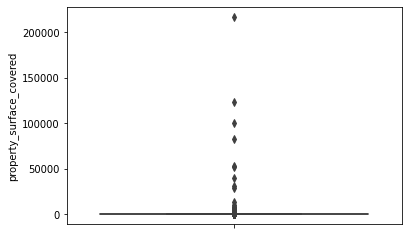

In [47]:
sns.boxplot(y=ds_atipicos.property_surface_covered)

property_price

In [48]:
#z-score
ds_atipicos['z_price']=st.zscore(ds_atipicos.property_price)

#z-score modificado
mediana_price = np.median(ds_atipicos.property_price)
MAD=np.median(np.absolute(ds_atipicos.property_price - mediana_price)) 
ds_atipicos['zm_price']=(ds_atipicos.property_price - mediana_price)*0.6745/MAD

In [49]:
ds_atipicos[ds_atipicos['z_price'] > 3 ]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,z_rooms,zm_rooms,z_bedrooms,zm_bedrooms,z_surface_total,z_surface_covered,z_price,zm_price
410,5.201,4.0,400.0,316.9845,2700000.0,1.660570,1.484574,1.842738,1.3490,0.254951,0.229415,7.893604,30.269667
411,5.201,4.0,400.0,316.9845,2700000.0,1.660570,1.484574,1.842738,1.3490,0.254951,0.229415,7.893604,30.269667
438,4.000,3.0,282.0,256.0000,2250000.0,0.818956,0.674500,0.980853,0.6745,0.151200,0.168449,6.459413,24.944667
448,5.000,4.0,304.0,294.0000,1200000.0,1.519717,1.349000,1.842738,1.3490,0.170544,0.206438,3.112967,12.519667
629,4.000,3.0,214.0,196.0000,1200000.0,0.818956,0.674500,0.980853,0.6745,0.091411,0.108466,3.112967,12.519667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
459724,8.000,3.0,285.0,272.0000,1250000.0,3.622001,3.372500,0.980853,0.6745,0.153838,0.184444,3.272321,13.111333
459729,6.000,3.0,271.0,265.0000,1250000.0,2.220479,2.023500,0.980853,0.6745,0.141528,0.177446,3.272321,13.111333
459755,8.000,5.0,431.0,415.0000,2800000.0,3.622001,3.372500,2.704622,2.0235,0.282208,0.327402,8.212313,31.453000
459764,8.000,4.0,383.0,383.0000,1700000.0,3.622001,3.372500,1.842738,1.3490,0.240004,0.295412,4.706512,18.436333


<AxesSubplot:ylabel='property_price'>

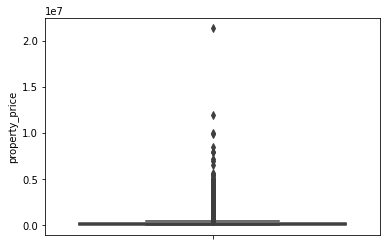

In [50]:
sns.boxplot(y=ds_atipicos.property_price)

### Detectar valores atípicos en los datos en forma multivariada

Utilizamos el metodo de Isolation Forest

In [51]:
from sklearn.ensemble import IsolationForest
#Creo el modelo
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=5, 
                          bootstrap=False, n_jobs=-1, random_state=1)

In [52]:
#Entreno y genero la predicción
ds_forest = ds_atipicos.drop(columns=["z_rooms","zm_rooms","z_bedrooms","zm_bedrooms","z_surface_total","z_surface_covered","z_price","zm_price"])
pred= iforest.fit_predict(ds_forest)

/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [53]:
#Almaceno scores y etiquetas
ds_forest['scores']=iforest.decision_function(ds_forest)
ds_forest['outlier_label']=pred

#Observaciones anómalas
ds_forest[ds_forest.outlier_label==-1]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,scores,outlier_label
58,10.000,10.0,394.0,244.0000,500000.0,-0.147300,-1
410,5.201,4.0,400.0,316.9845,2700000.0,-0.129843,-1
411,5.201,4.0,400.0,316.9845,2700000.0,-0.129843,-1
438,4.000,3.0,282.0,256.0000,2250000.0,-0.098962,-1
448,5.000,4.0,304.0,294.0000,1200000.0,-0.039906,-1
...,...,...,...,...,...,...,...
459842,3.000,2.0,8136.0,6472.0000,203550.0,-0.160392,-1
459847,4.000,3.0,18096.0,8568.0000,324558.0,-0.172535,-1
459849,3.000,2.0,7720.0,5970.0000,167894.0,-0.160355,-1
459922,10.000,9.0,145.0,145.0000,300000.0,-0.099277,-1


In [54]:
#Cantidad de obs. anómalas
ds_forest.outlier_label.value_counts()

 1    84721
-1     4459
Name: outlier_label, dtype: int64

#### property_price vs property_rooms

/home/fanu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


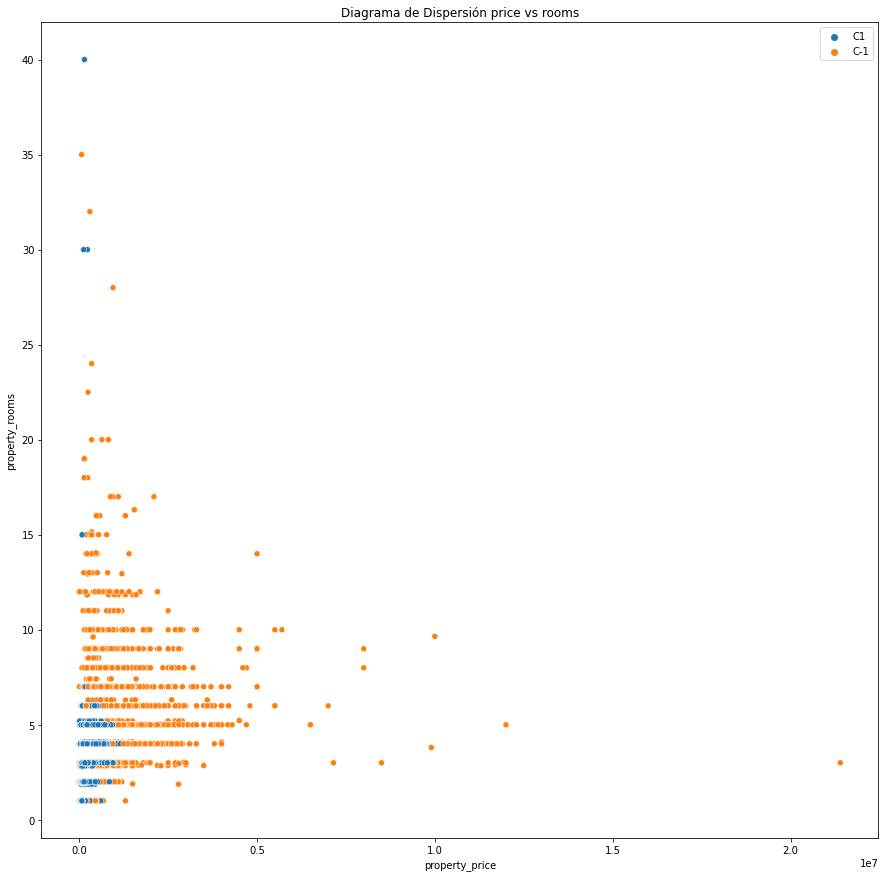

In [55]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(ds_forest['property_price'],ds_forest['property_rooms'],hue=color)
plt.title('Diagrama de Dispersión price vs rooms')
plt.show()

#### property_bedrooms vs property_rooms

/home/fanu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


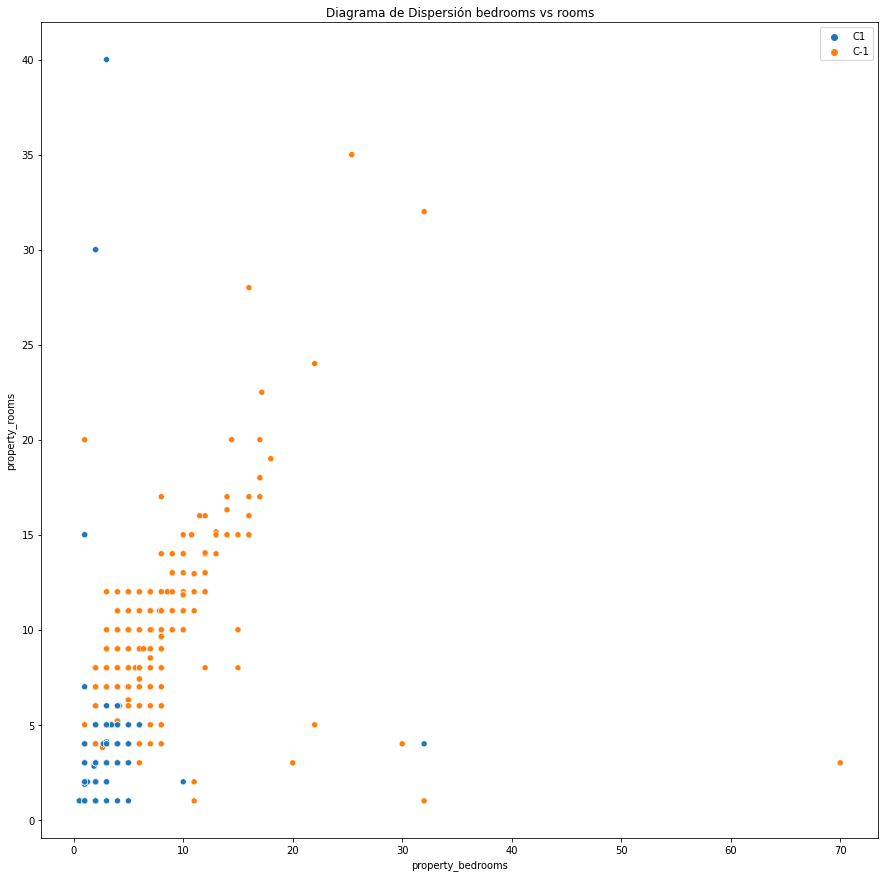

In [56]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(ds_forest['property_bedrooms'],ds_forest['property_rooms'],hue=color)
plt.title('Diagrama de Dispersión bedrooms vs rooms')
plt.show()

#### property_price vs property_surface_covered

/home/fanu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


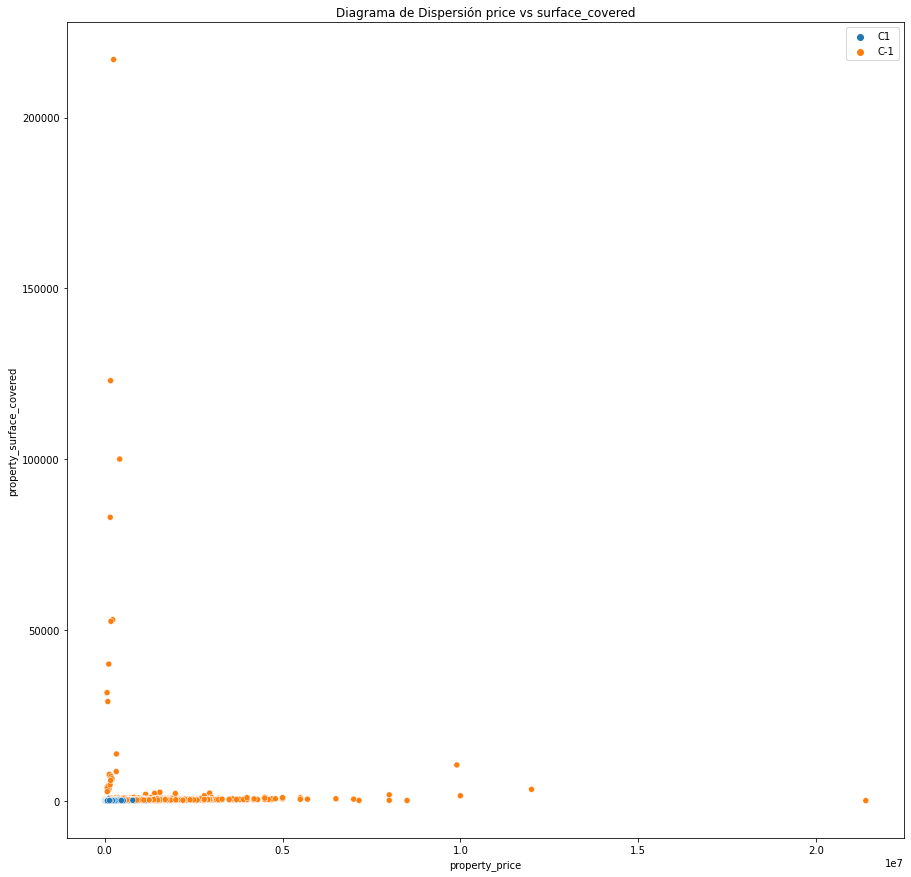

In [57]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(ds_forest['property_price'],ds_forest['property_surface_covered'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_covered')
plt.show()

#### property_price vs property_surface_total

/home/fanu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


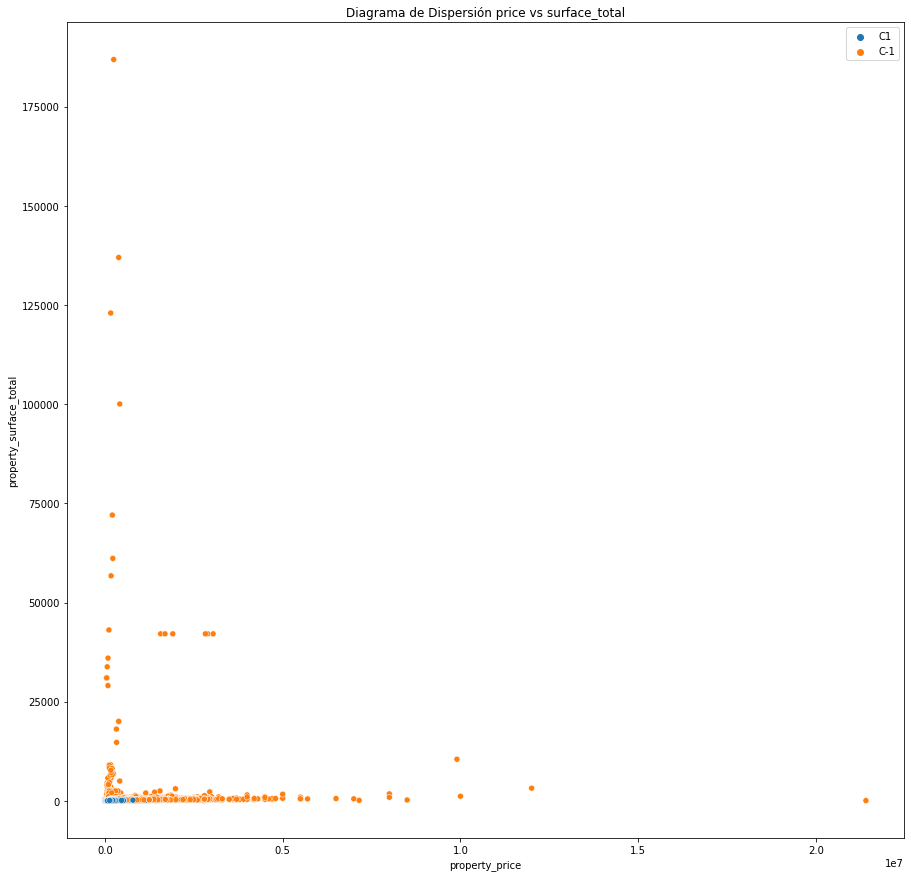

In [58]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(ds_forest['property_price'],ds_forest['property_surface_total'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_total')
plt.show()

### Características y tratamientos de los datos atípicos detectados.

Con los analisis univariados y multivariados que analizamos, concluimos que la mayoria de los datos atipicos los encontramos en valores relacionados con las variables "property_bedrooms", "property_rooms" y "property_price".

Luego de los distintos análisis del dataset pudimos obvservar que al aplicar el método univariado encontramos aquellos outliers con valores extremos en relación a cada columna en particular. En cambio, al implementar el modelo de Isolation Forest para valores atípicos multivariados obtuvimos otras muestras a tener en cuenta como outliers para un mejor tratamiento de los mismos.
Decidimos eliminar solo aquellos valores atipicos, que encontramos en el analisis multivariado y univariado de "property_bedrooms", "property_rooms" y "property_price". En cuanto al analisis de "property_surface_covered" y "property_surface_total" decidimos eliminar todos los valores atipicos obtenidos con el modelo z-score 

In [59]:
indice_surface_total = ds_atipicos[ds_atipicos['z_surface_total'] > 3 ].index.to_list()
indice_surface_covered = ds_atipicos[ds_atipicos['z_surface_covered'] > 3 ].index.to_list()
indice_a_eliminar_directo = indice_surface_total + indice_surface_covered
ds_atipicos = ds_atipicos.drop(index=indice_a_eliminar_directo)

In [60]:
from collections import OrderedDict
from iteration_utilities import duplicates # hay que instalar iteration_utilities "pip install iteration_utilities"
from iteration_utilities import unique_everseen
indice_price = ds_atipicos[ds_atipicos['z_price'] > 3 ].index.to_list()
indice_bedrooms = ds_atipicos[ds_atipicos['z_bedrooms'] > 3 ].index.to_list()
indice_rooms = ds_atipicos[ds_atipicos['z_rooms'] > 3 ].index.to_list()
indice_multi_variable = ds_forest[ds_forest.outlier_label==-1].index.to_list()
indice_a_eliminar = indice_price + indice_bedrooms + indice_rooms
indice_a_eliminar = list(OrderedDict.fromkeys(indice_a_eliminar))
indice_a_eliminar = indice_a_eliminar + indice_multi_variable
a = list(unique_everseen(duplicates(indice_a_eliminar)))
ds_atipicos = ds_atipicos.drop(index=a)
ds_atipicos_copia = ds_atipicos_copia.drop(index = a)

### Analizar la relación entre el precio de venta y los metros de superficie

In [61]:
iforest = IsolationForest(n_estimators=100, max_samples='auto', 
                          contamination=0.05, max_features=5, 
                          bootstrap=False, n_jobs=-1, random_state=1)

In [62]:
#Entreno y genero la predicción
ds_forest = ds_atipicos.drop(columns=["z_rooms","zm_rooms","z_bedrooms","zm_bedrooms","z_surface_total","z_surface_covered","z_price","zm_price"])
pred= iforest.fit_predict(ds_forest)

/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [63]:
ds_forest['scores']=iforest.decision_function(ds_forest)
ds_forest['outlier_label']=pred

#Observaciones anómalas
ds_forest[ds_forest.outlier_label==-1]

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,scores,outlier_label
659,6.0,4.0,236.0,210.0,849000.0,-0.077416,-1
713,7.0,4.0,201.0,111.0,250000.0,-0.041471,-1
1212,4.0,3.0,195.0,195.0,1090000.0,-0.036940,-1
1362,5.0,4.0,313.0,163.0,250000.0,-0.016860,-1
1473,4.0,3.0,244.0,244.0,598000.0,-0.024265,-1
...,...,...,...,...,...,...,...
459767,6.0,3.0,230.0,226.0,690000.0,-0.045602,-1
459786,5.0,4.0,258.0,258.0,380000.0,-0.024578,-1
459789,7.0,3.0,228.0,228.0,610000.0,-0.078572,-1
459813,6.0,5.0,143.0,143.0,198000.0,-0.031270,-1


In [64]:
#Cantidad de obs. anómalas
ds_forest.outlier_label.value_counts()

 1    82616
-1     4349
Name: outlier_label, dtype: int64

/home/fanu/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


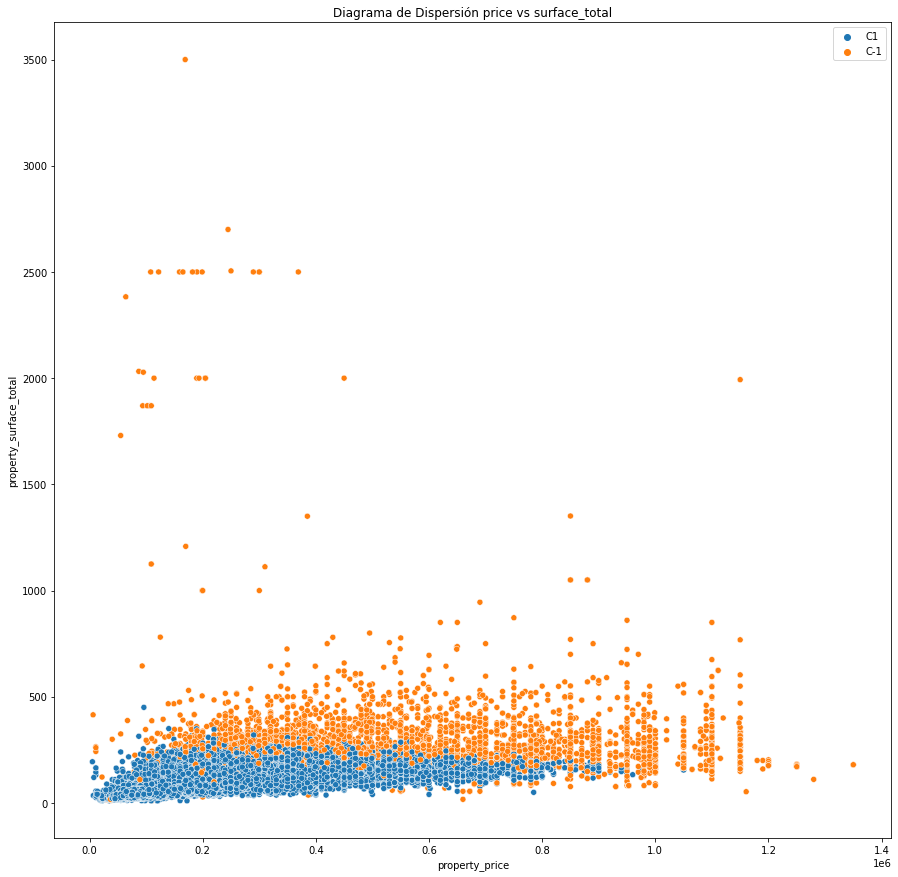

In [65]:
#Grafico dispersograma
color=[f"C{n}" for n in (ds_forest['outlier_label'].values)]

plt.figure(figsize=(15,15))
sns.scatterplot(ds_forest['property_price'],ds_forest['property_surface_total'],hue=color)
plt.title('Diagrama de Dispersión price vs surface_total')
plt.show()

Los outliers en casos multivariados como los que analizamos previamente, pueden provocar un efecto de enmascaramietno que se produce cuando un grupo de outliers esconden a otros. Es decir, los outliers enmascarados se haran visibles cuando se eliminen los outliers que los esconden.
En nuestro caso, observamos como al eliminar la primer tanda de valores atipicos y realizar el analisis nuevamente, encontramos nuevos outliers.

# Reduccion De La Dimensionalidad

In [66]:
ds_prop_reducido = ds_atipicos_copia.copy()

Analizamos nuevamente las correlaciones entre las variables para evaluear posibles canidatos para reducir la dimension del dataset. Se puede ver la fuerte correlación entre property_rooms y property_bedrooms, por lo cual se los puede considerar candidatos para la reducción

In [67]:
ds_prop_filtrado.corr()

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.138256,-0.033763,-0.035218,0.008173,0.002341,0.148432
longitud,-0.138256,1.000000,0.012548,0.017666,0.001932,0.003564,0.123029
property_rooms,-0.033763,0.012548,1.000000,0.874508,0.064721,0.073661,0.483347
property_bedrooms,-0.035218,0.017666,0.874508,1.000000,0.066470,0.072473,0.417789
property_surface_total,0.008173,0.001932,0.064721,0.066470,1.000000,0.623842,0.082119
property_surface_covered,0.002341,0.003564,0.073661,0.072473,0.623842,1.000000,0.054127
property_price,0.148432,0.123029,0.483347,0.417789,0.082119,0.054127,1.000000


Analizamos la importancia de los atributos

In [68]:
ds_prop_filtrado_arbol = ds_prop_filtrado.dropna()

#One Hot Encoding para variables categoricas
variables_reemplazadas = ["place_l2", "place_l3", "operation"]
ds_prop_filtrado_arbol = pd.get_dummies(ds_prop_filtrado_arbol, columns=variables_reemplazadas, drop_first=True)

#Creo dataset con los features que se van a usar para clasificar
variables_eliminadas = ['property_price', 'property_title', "property_type", "property_currency", "created_on", "start_date", "end_date"]
ds_prop_filtrado_x = ds_prop_filtrado_arbol.drop(variables_eliminadas, axis='columns', inplace=False)

#Creo dataset con la variable target
ds_prop_filtrado_y = ds_prop_filtrado_arbol['property_price'].copy()


x_train, x_test, y_train, y_test = train_test_split(ds_prop_filtrado_x, 
                                                    ds_prop_filtrado_y, 
                                                    test_size=0.1, #proporción 90/10 
                                                    random_state=2) #semilla

tree_model = tree.DecisionTreeClassifier(criterion="entropy",max_depth=20, min_samples_leaf=5)

#Entrenamos el modelo
model = tree_model.fit(X=x_train, y=y_train)
y_pred = model.predict(x_test)

#Calculamos las métricas en el conjunto de evaluación
accuracy=accuracy_score(y_test, y_pred)
print("Accuracy: " + str(accuracy))





Accuracy: 0.1263713373142619


In [69]:
#Muestra valores reales
y_test.values[:18]

array([ 64900.,  75000., 259000., 140000.,  95000., 285000., 210000.,
       105000., 670000., 151000., 105000.,  73000.,  75000., 156000.,
        68000., 144000.,  86000.,  82000.])

In [70]:
#Muestra valores_predecidos
y_pred[:18]

array([ 79000.,  63000., 229000., 105000.,  95000., 285000., 255000.,
        79900., 670000., 151000.,  89000.,  69900.,  70000., 145000.,
        68000.,  88900., 104999.,  82000.])

In [71]:
#Importancia de los atributos de ayor a menor
sorted(list(zip(ds_prop_filtrado_x.columns.to_list(), model.feature_importances_)), key=lambda x: -x[1])

[('latitud', 0.2695080694930687),
 ('longitud', 0.24916308959601619),
 ('property_surface_covered', 0.2399547676738835),
 ('property_surface_total', 0.18488620531914365),
 ('property_rooms', 0.01599901787918852),
 ('property_bedrooms', 0.009665122241263912),
 ('place_l3_Caballito', 0.00876905003790413),
 ('place_l3_Puerto Madero', 0.006319166400503494),
 ('place_l3_Palermo', 0.003025075436139495),
 ('place_l3_Belgrano', 0.0015254288628405335),
 ('place_l3_Villa Urquiza', 0.0010513803050324745),
 ('place_l3_Flores', 0.0010012754712841964),
 ('place_l3_Recoleta', 0.0009460509743572982),
 ('place_l3_Balvanera', 0.0007919311826799269),
 ('place_l3_Villa Crespo', 0.0007535757222912567),
 ('place_l3_Villa Pueyrredón', 0.000686421651880465),
 ('place_l3_Barracas', 0.00048559950557097996),
 ('place_l3_Almagro', 0.0004492549396910204),
 ('place_l3_Floresta', 0.0004423359244034303),
 ('place_l3_Villa del Parque', 0.00041166288097055234),
 ('place_l3_Villa Devoto', 0.00037333741219337417),
 ('pla

Analizamos la varianza de las variables

In [72]:
ds_prop_filtrado.var()

<ipython-input-72-0a2554f4eb1e>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ds_prop_filtrado.var()


latitud                     6.976236e-04
longitud                    1.457336e-03
property_rooms              2.008242e+00
property_bedrooms           1.260740e+00
property_surface_total      9.496260e+05
property_surface_covered    1.036975e+06
property_price              9.845001e+10
dtype: float64

Hacemos PCA para analizar posibles reducciones

In [73]:
ds_prop_filtrado_pca = ds_prop_filtrado.dropna()
 
columnas_elegidas = ["latitud", "longitud", "property_rooms", "property_surface_total", "property_surface_covered"]

x = ds_prop_filtrado_pca.loc[:, columnas_elegidas].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components=5) 
x_transformada = pca.fit_transform(x)

pca_df_aux = pd.DataFrame(data = x_transformada
             , columns = ['cp_1', 'cp_2','cp_3','cp_4', 'cp_5'])


print("Variabilidad explicada por cada componente:"  + str(pca.explained_variance_ratio_))

Variabilidad explicada por cada componente:[0.34467764 0.22806318 0.19511868 0.17401763 0.05812287]


Vemos como con cuatro componentes explicamos el 94% de la variabilidad

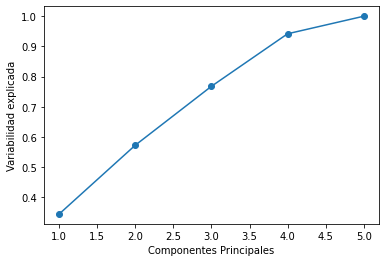

In [74]:
variabilidad_explicada = pca.explained_variance_ratio_
list_x = list(range(1, len(variabilidad_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales
plt.figure(figsize=(6, 4))
plt.plot(list_x, variabilidad_explicada.cumsum(), '-o')
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

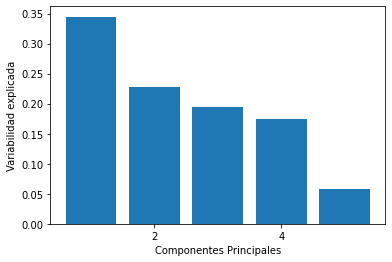

In [75]:
list_x = list(range(1, len(variabilidad_explicada)+1))

# Grafico varianza explicada y cantidad de componentes principales

plt.locator_params('x', nbins = 5)
plt.bar(list_x, variabilidad_explicada)
plt.xlabel(r'Componentes Principales')
plt.ylabel('Variabilidad explicada')
plt.show()

# Agrupamiento


## Clustering

In [165]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans

In [166]:
ds_kmeans = ds_atipicos_copia.copy()
columnas = ["start_date", "end_date", "created_on", "place_l2", "place_l3", "operation", "property_type", "property_currency", "property_title", "latitud", "longitud"]
ds_kmeans.drop(columns = columnas, inplace = True)

In [167]:
from sklearn.preprocessing import scale, MinMaxScaler

scaler = MinMaxScaler()
ds_kmeans_escalado = scaler.fit_transform(ds_kmeans) 

In [168]:
kmeans = KMeans(2, random_state=123)

kmeans.fit(ds_kmeans)

KMeans(n_clusters=2, random_state=123)

In [169]:
clusters = kmeans.predict(ds_kmeans)
ds_kmeans["cluster"] = clusters
ds_kmeans

,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,cluster
42,3.0,2.0,58.0000,55.0,82900.0,0
43,4.0,3.0,70.0000,70.0,99000.0,0
49,4.0,2.0,133.7565,104.0,146000.0,0
51,4.0,2.0,107.0934,73.0,250000.0,0
53,2.0,1.0,61.0000,46.0,100000.0,0
...,...,...,...,...,...,...
460072,4.0,3.0,130.0000,100.0,220000.0,0
460073,3.0,2.0,68.0000,60.0,161000.0,0
460074,1.0,1.0,51.0000,30.0,75500.0,0
460075,1.0,1.0,37.0000,31.0,74500.0,0


### Elbow

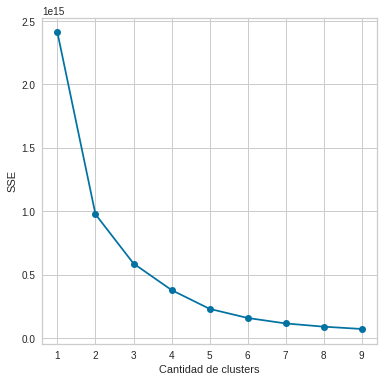

In [159]:
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(ds_kmeans)
    sse.append(km.inertia_)

# Grafico el SSE por K
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Cantidad de clusters')
plt.ylabel('SSE')
plt.show()

### Silhouette

In [ ]:
from sklearn.metrics import silhouette_score

list_k = list(range(2, 10))

for n_clusters in list_k:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(ds_kmeans)

    score = silhouette_score (ds_kmeans, preds)
    print ("For n_clusters =" + str(n_clusters) + " silhouette score is " + str(score))

/home/fanu/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


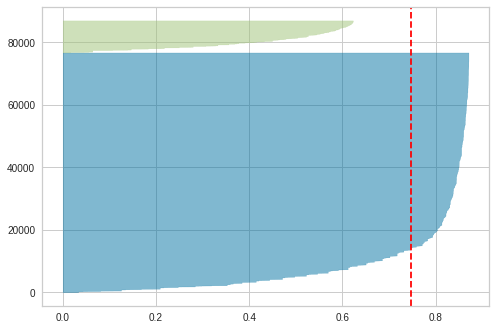

In [170]:
from yellowbrick.cluster import SilhouetteVisualizer

# Visualizamos el gráfico de silueta
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')    # Instancio el visualizador
visualizer.fit(ds_kmeans.drop(columns=["cluster"]))
plt.show()

### Analisis por grupo
